In this notebook, transfer learning is being performed for single label classification task using the ResNet-101 pretrained model.

The two methods of transfer learning, model fine-tuning and model as fixed feature extractor, are put against each other for comparison.

In conclusion, for this specfic task, model fine-tuning turned out to be more performant than model as fixed feature extractor.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
# data augmentation and normalization for training and validation
data_transforms = {
 'Train': transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
 ]),
 'Val': transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
 ]),
}

In [3]:
# data path
data_dir = "Classification Dataset/"
# load data
datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train', 'Val']}

# define train and val dataloaders
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=5, shuffle=True, num_workers=0) for x in ['Train', 'Val']}

# define dataset sizes
dataset_sizes = {x: len(datasets[x]) for x in ['Train', 'Val']}
print(dataset_sizes)

class_names = datasets['Val'].classes
print(class_names)

{'Train': 233, 'Val': 37}
['Bread', 'Coffee', 'Pasta']


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def train_model(model, lossFunction, optimizer, scheduler, num_epochs=100):
 since = time.time()
 
 best_model_wts = copy.deepcopy(model.state_dict())
 best_acc = 0.0
 
 for epoch in range(num_epochs):
  print('epoch {}/{}'.format(epoch, num_epochs - 1))
  print('-' * 10)
  
  # each epoch has a training and validation phase
  for phase in ['Train', 'Val']:
   if phase == 'Train':
    model.train() # set model to training mode
   else:
    model.eval() # set model to evaluation mode
    
   running_loss = 0.0
   running_corrects = 0
   
   # iterate over data
   for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward
    # track history if only in train
    with torch.set_grad_enabled(phase == 'Train'):
     outputs = model(inputs)
     _, preds = torch.max(outputs, 1)
     loss = lossFunction(outputs, labels)
     
     # backward + optimize only if in training phase
     if phase == 'Train':
      loss.backward()
      optimizer.step()
    
    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
   if phase == 'Train':
    scheduler.step()
    
   epoch_loss = running_loss / dataset_sizes[phase]
   epoch_acc = running_corrects.double() / dataset_sizes[phase]
   
   print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
   
   # deep copy the model
   if phase == 'Val' and epoch_acc > best_acc:
    best_acc = epoch_acc
    best_model_wts = copy.deepcopy(model.state_dict())
   
  
  print()
  
 time_elapsed = time.time() - since
 print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
 print('Best val Acc: {:4f}'.format(best_acc))
 
 # laod best model weights
 model.load_state_dict(best_model_wts)
 return model

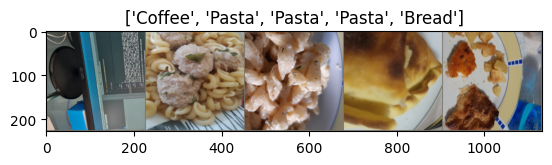

In [6]:
def imshow(inp, title=None):
 """Imshow for Tensor."""
 inp = inp.numpy().transpose((1, 2, 0))
 mean = np.array([0.485, 0.456, 0.406])
 std = np.array([0.229, 0.224, 0.225])
 inp = std * inp + mean
 inp = np.clip(inp, 0, 1)
 plt.imshow(inp)
 if title is not None:
  plt.title(title)
 plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def visualize_model(model, num_images=8):
 was_training = model.training
 model.eval()
 images_so_far = 0
 fig = plt.figure()
 
 with torch.no_grad():
  for i, (inputs, labels) in enumerate(dataloaders['Val']):
   inputs = inputs.to(device)
   labels = labels.to(device)
   
   outputs = model(inputs)
   _, preds = torch.max(outputs, 1)
   
   for j in range(inputs.size()[0]):
    images_so_far += 1
    ax = plt.subplot(num_images//2, 2, images_so_far)
    ax.axis('off')
    ax.set_title('predicted: {}'.format(class_names[preds[j]]))
    imshow(inputs.cpu().data[j])
    
    if images_so_far == num_images:
     model.train(mode=was_training)
     return
  model.train(mode=was_training)
   

In [9]:
# transfer learning by fine-tuning the pretrained resnet101 model
# load ResNet101 model
resnet101 = models.resnet101(pretrained=True)
# resnet101 = models.resnet101(weights=True) # if pretrained=True does not work
print(resnet101)
# set the resnet param.requires_grad to = True to calculate the gradients, so that the model fine-tunes the weights of the pretrained network
# by continuing the backpropagation
for param in resnet101.parameters():
 param.requires_grad = True
 
# get the number of input features of the last layer (fully connected layer) of the model
# because we are going to replace the last layer with a new fully connected layer
in_ftrs = resnet101.fc.in_features

# reset the final fully connected layer of the pretrained resnet101 model
resnet101.fc = nn.Linear(in_ftrs, len(class_names))

resnet_finetuning = resnet101.to(device)

c:\Users\alshe\anaconda3\envs\venv1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alshe\anaconda3\envs\venv1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

the last fully connected layer in the above model is the target layer that will be replaced. currently, the out_features = 1000, this means that the model is predicting 1000 classes. we will change this.

model optimization:
- optimization algorithm
- learning rate decay
- loss function

hyperparameters need to be set before training the model, such as number of epochs, learning rate, etc.
whereas parameters are obtained during the training, there is no way to get them in advance, such as weights and biases of neural networks.

In [10]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [11]:
# define optimization algorithm
optimizer = optim.Adam(resnet_finetuning.parameters(), lr=0.00001)

# decay the learning rate by a factor of 0.1 every 7 epochs
decay_learning_rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# define loss function
loss_function = nn.CrossEntropyLoss()

In [12]:
model_finetuning = train_model(resnet_finetuning, loss_function, optimizer, decay_learning_rate, num_epochs=20)
torch.save(model_finetuning, 'resnet101_finetuning.pth')

epoch 0/19
----------
Train Loss: 0.9570 Acc: 0.5451
Val Loss: 0.7308 Acc: 0.8378

epoch 1/19
----------
Train Loss: 0.6922 Acc: 0.7639
Val Loss: 0.4616 Acc: 0.9459

epoch 2/19
----------
Train Loss: 0.5711 Acc: 0.7940
Val Loss: 0.3577 Acc: 0.9459

epoch 3/19
----------
Train Loss: 0.4752 Acc: 0.8627
Val Loss: 0.2075 Acc: 0.9730

epoch 4/19
----------
Train Loss: 0.4214 Acc: 0.8884
Val Loss: 0.4614 Acc: 0.9459

epoch 5/19
----------
Train Loss: 0.4069 Acc: 0.8670
Val Loss: 0.0946 Acc: 1.0000

epoch 6/19
----------
Train Loss: 0.3488 Acc: 0.8884
Val Loss: 0.1851 Acc: 0.9730

epoch 7/19
----------
Train Loss: 0.3811 Acc: 0.8627
Val Loss: 0.3653 Acc: 0.9459

epoch 8/19
----------
Train Loss: 0.3184 Acc: 0.8970
Val Loss: 0.1159 Acc: 0.9730

epoch 9/19
----------
Train Loss: 0.2925 Acc: 0.9142
Val Loss: 0.5130 Acc: 0.9189

epoch 10/19
----------
Train Loss: 0.3620 Acc: 0.8584
Val Loss: 0.0747 Acc: 1.0000

epoch 11/19
----------
Train Loss: 0.2912 Acc: 0.9142
Val Loss: 0.2793 Acc: 0.9459

ep

In [13]:
resnet_finetuning = torch.load('resnet101_finetuning.pth')

C:\Users\alshe\AppData\Local\Temp\ipykernel_41256\2545567296.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_finetuning = torch.load('resnet101_finetuning.pth')


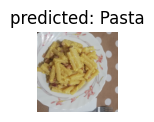

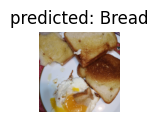

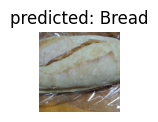

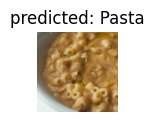

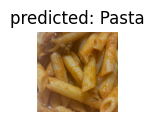

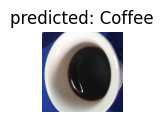

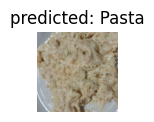

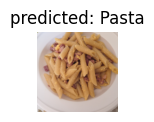

In [14]:
visualize_model(resnet_finetuning)

what's above is one variation for transfer learning, and it is called "fine-tuning the pretrained model", where the weights for all the layers get modified.


now, another method to perform transfer learning is called "pretrained model as fixed feature extractor", where the last fully connected layer is replaced with another fully connected layer with random wights, and only this layer is trained.

In [15]:
# load the resnet101 model
resnet101 = models.resnet101(pretrained=True)

for param in resnet101.parameters():
 param.requires_grad = False # freeze the weights of the pretrained model so that only the weights of the new fully connected layer are updated
 
in_features = resnet101.fc.in_features

# replace the last layer of the pretrained model with a new fully connected layer
resnet101.fc = nn.Linear(in_features, len(class_names))

# only the weights of the new fully connected layer are updated
resnet_featureExtractor = resnet101.to(device)

c:\Users\alshe\anaconda3\envs\venv1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alshe\anaconda3\envs\venv1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# loss function
loss_function = nn.CrossEntropyLoss()

# observe that only parameters of final layer are being optimized as opposed to before
optimizer = optim.SGD(resnet_featureExtractor.fc.parameters(), lr=0.00001)

# decay the learning rate by a factor of 0.1 every 7 epochs
decay_learning_rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [17]:
model_featureExtractor = train_model(resnet_featureExtractor, loss_function, optimizer, decay_learning_rate, num_epochs=20)
torch.save(model_featureExtractor, 'resnet101_featureExtractor.pth')

epoch 0/19
----------
Train Loss: 1.1965 Acc: 0.2103
Val Loss: 1.0855 Acc: 0.3784

epoch 1/19
----------
Train Loss: 1.1819 Acc: 0.2017
Val Loss: 1.0974 Acc: 0.3514

epoch 2/19
----------
Train Loss: 1.1837 Acc: 0.1803
Val Loss: 1.0930 Acc: 0.3784

epoch 3/19
----------
Train Loss: 1.1656 Acc: 0.2446
Val Loss: 1.1206 Acc: 0.2432

epoch 4/19
----------
Train Loss: 1.1589 Acc: 0.2489
Val Loss: 1.1107 Acc: 0.1892

epoch 5/19
----------
Train Loss: 1.1557 Acc: 0.2661
Val Loss: 1.1100 Acc: 0.2703

epoch 6/19
----------
Train Loss: 1.1512 Acc: 0.1888
Val Loss: 1.1115 Acc: 0.2162

epoch 7/19
----------
Train Loss: 1.1423 Acc: 0.2446
Val Loss: 1.1211 Acc: 0.1892

epoch 8/19
----------
Train Loss: 1.1430 Acc: 0.2361
Val Loss: 1.1129 Acc: 0.2162

epoch 9/19
----------
Train Loss: 1.1464 Acc: 0.2275
Val Loss: 1.1116 Acc: 0.2162

epoch 10/19
----------
Train Loss: 1.1399 Acc: 0.2489
Val Loss: 1.0940 Acc: 0.2703

epoch 11/19
----------
Train Loss: 1.1469 Acc: 0.2146
Val Loss: 1.1120 Acc: 0.2162

ep

In [18]:
resnet_featureExtractor = torch.load('resnet101_featureExtractor.pth')

C:\Users\alshe\AppData\Local\Temp\ipykernel_41256\1107171569.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_featureExtractor = torch.load('resnet101_featureExtra

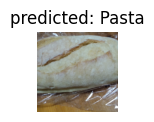

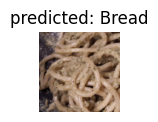

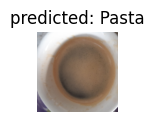

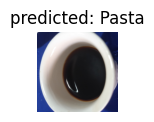

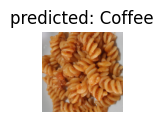

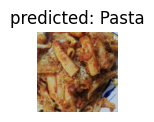

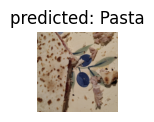

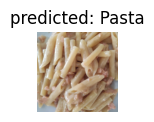

In [19]:
visualize_model(resnet_featureExtractor)